In [100]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from scipy.signal import chirp

**Sound data**

Sound will normally be time series data, but can also be supplied in different transformations. Here we will look at a simple example of how a chirp signal looks as time series, as a spectrogram and how you could make features from the energies in areas of the spectrogram.

You are not expected to know this, it is just to give a background to the data we will work with in this notebook.

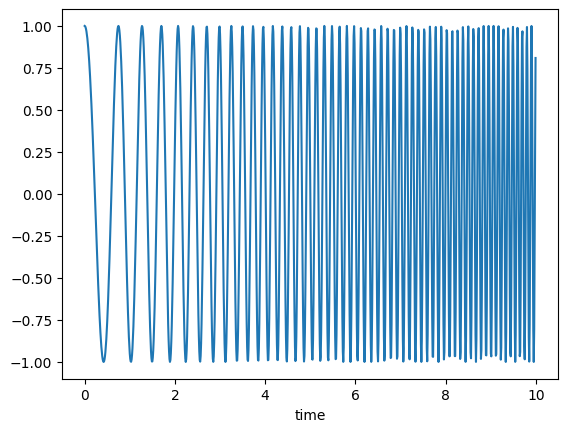

In [101]:
# Generate timeseries of a chirp
fs = 100
t = np.arange(0, 10, 1/fs)
y = chirp(t, 1, 10, 10, method="linear")
plt.plot(t, y)
plt.xlabel("time");

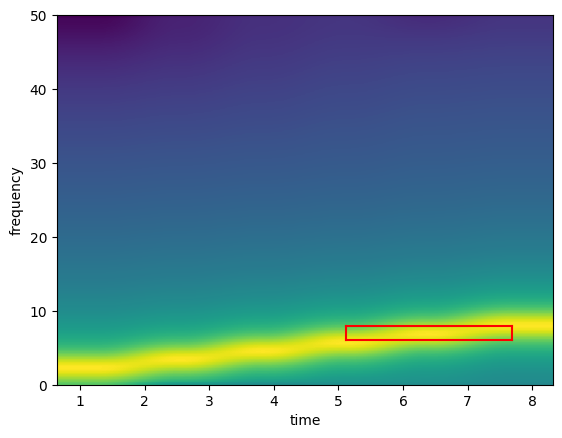

In [102]:
# Generate a spectrogram of the chirp
spec, freq, ts, im = plt.specgram(y, Fs=fs)
plt.xlabel("time")
plt.ylabel("frequency")

# Plot a box in which we can sum up the energy
plt.plot([ts[3], ts[5]], [6, 6], 'r')
plt.plot([ts[3], ts[5]], [8, 8], 'r')
plt.plot([ts[3], ts[3]], [6, 8], 'r')
plt.plot([ts[5], ts[5]], [6, 8], 'r');

We can integrate up the energy over certain frequency bands and time periods, this integrated value is then used as a feature. So the red rectangle here could for example be the source of one of many features from this spectrogram, probably one with a relatively high value given that it hits the high energy band created by the chirp.

**Sonar Dataset**

This dataset consists of sonar chirps bouncing off different surfaces. The chirp is sent out and bounces on either a mine (metal cylinder) or a rock and the returning sound is then recorded. The features in the dataset represents the energy within a particular frequency band, integrated over a certain period of time for signals recorded from different aspect angles.

Manual feature extraction like this is very common in many fields, and can make learning much faster and easier by giving the model features containing important information for the task we want performed so it does not have to find that through learning.

There is one catch though, when simplifying the data like this we can also remove information contained in the original data. The model do get some new information in that some human thought this transform might be good, and it does not have to try to learn from the complex raw sound, but as with almost everything there is a tradeoff with manually creating features. A sufficiently complex model could find any of these transformation by it self given enough data, and it might also find more efficient transformations.

In this case we do not have a lot of data, so doing a this transformation to extract features could be a good idea if the features are good. This will allow simpler models to be used, and can speed up learning and prediction accuracy for them.

In [103]:
# Download dataset from url, save it to sonar.csv
!wget -O sonar.csv https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data

--2024-09-24 21:21:45--  https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘sonar.csv’

sonar.csv               [ <=>                ]  85.72K  --.-KB/s    in 0.03s   

2024-09-24 21:21:45 (3.18 MB/s) - ‘sonar.csv’ saved [87776]



In [104]:
data = pd.read_csv("sonar.csv", header=None)
data.iloc[:, 60] = 1 * (data.iloc[:, 60] == 'M') # Replace labels M and R with 1 and 0
print(len(data))

208


**Exploring the data**

In [105]:
# Inspect 5 random samples
data.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
20,0.0473,0.0509,0.0819,0.1252,0.1783,0.3070,0.3008,0.2362,0.3830,0.3759,...,0.0193,0.0118,0.0064,0.0042,0.0054,0.0049,0.0082,0.0028,0.0027,0
203,0.0187,0.0346,0.0168,0.0177,0.0393,0.1630,0.2028,0.1694,0.2328,0.2684,...,0.0116,0.0098,0.0199,0.0033,0.0101,0.0065,0.0115,0.0193,0.0157,1
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,0
121,0.0162,0.0041,0.0239,0.0441,0.0630,0.0921,0.1368,0.1078,0.1552,0.1779,...,0.0173,0.0135,0.0114,0.0062,0.0157,0.0088,0.0036,0.0053,0.0030,1
48,0.0190,0.0038,0.0642,0.0452,0.0333,0.0690,0.0901,0.1454,0.0740,0.0349,...,0.0093,0.0118,0.0112,0.0094,0.0140,0.0072,0.0022,0.0055,0.0122,0


**Histograms**

In pandas you can plot histograms over all features with `data.hist()` as follows.

0.0309


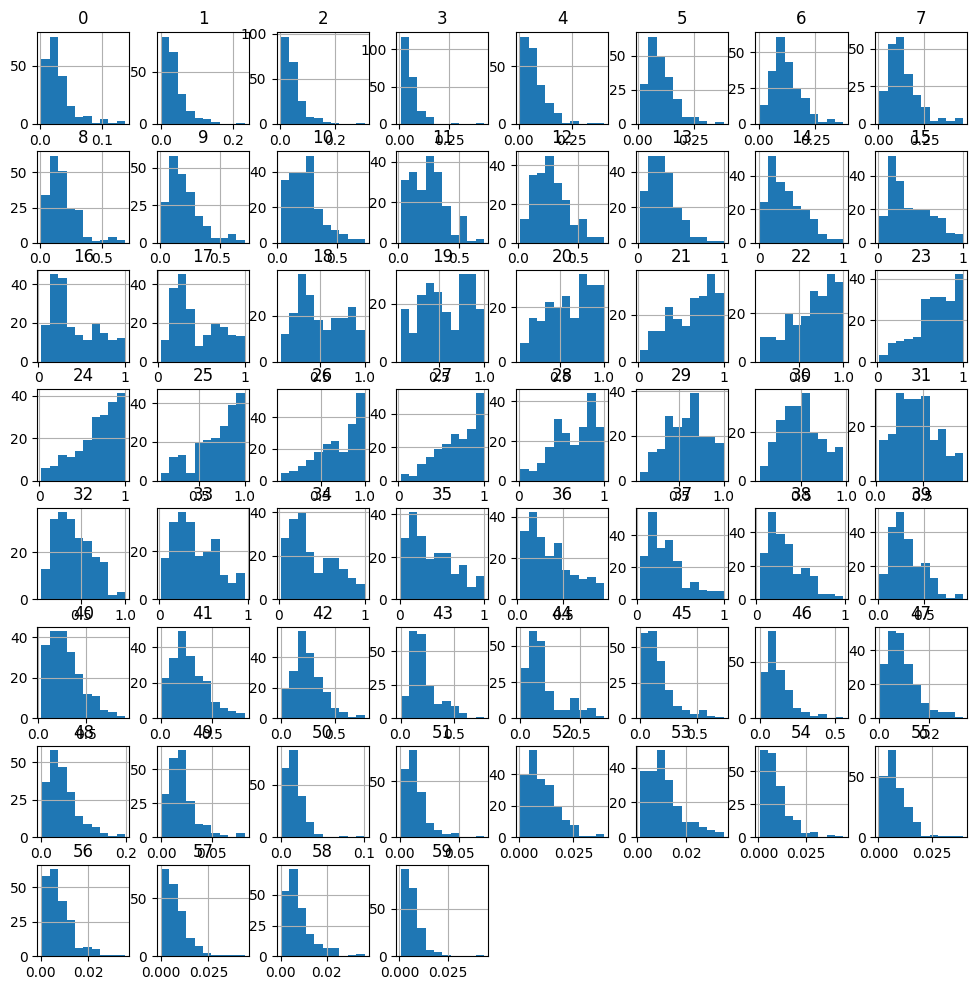

In [106]:
data.hist(figsize=(12, 12));
print(data[1][94])

Your task is to create your own version of this where the histogram is colored according to what label the contributing datapoints have, the labels are in the last column.

Then take a look at [docs](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.hist.html) for pyplot histograms and especially look at the stacked keyword.

Figure out how to split up all values of a feature corresponding according to the label 0 (rock) or 1 (mine), and then use `hist` to plot them stacked on eachother to look something like

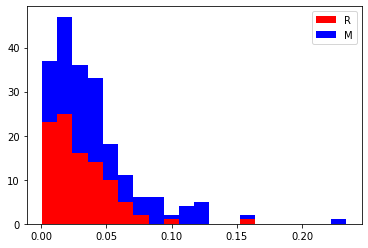

Create a figure with subplots in a grid and loop over them and plot a histogram of corresponding feature in each.

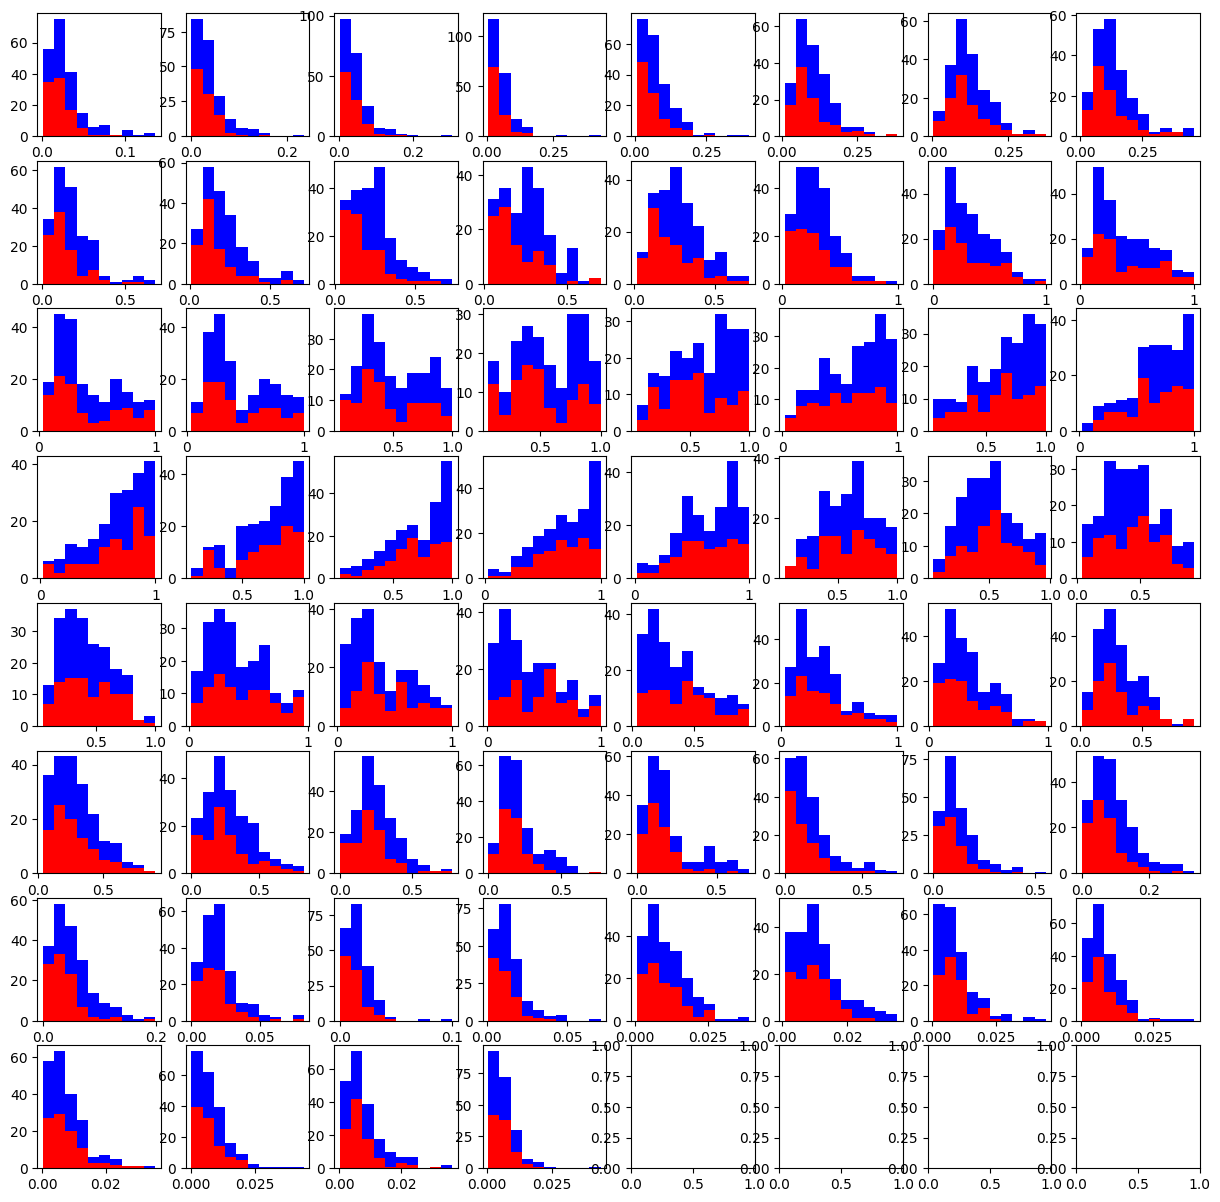

In [107]:
fig, axes = plt.subplots(8, 8, figsize=(15, 15))
for i in range(60):
    ax = axes[i // 8, i % 8]
    rock = []
    mine = []
    for row in range(208):
      if data[60][row] == 0:
         rock = rock + [data[i][row]]
      else:
         mine = mine + [data[i][row]]
    ax.hist([rock, mine], histtype = 'barstacked', color = ("red", "blue"))

**Scatter Matrix**

Pandas also has a plotting tool called `scatter_matrix` which can give good insight in how the data is spread for combinations of features. We can also supply colors to use for each datapoint, and with that we can create scatterplots over how the labels are distributed for combinations of features. This is very similar to what we just created in 5.1, but for combinations of features instead of for evey feature by it self.

Using either this or your plot from previous task and find maybe 5 features that seem like they contain information for classification. Try the first classification task for both all features and your selected features and see if you managed to choose good features.

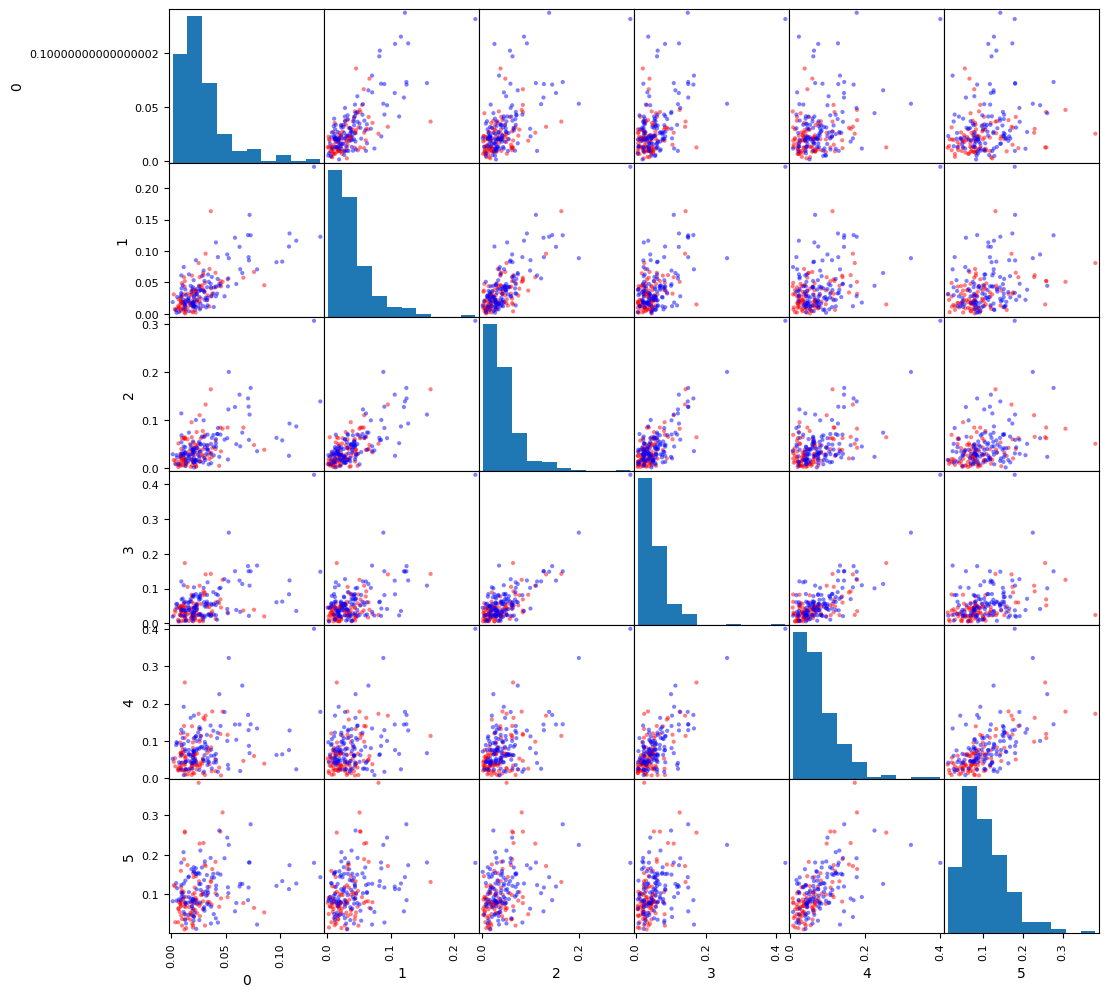

In [108]:
cols = list(map(lambda x: "red" if x == 0 else "blue", data.iloc[:,60]))
somefeatures = range(0, 6) # change here to study other features
pd.plotting.scatter_matrix(data.iloc[:,somefeatures], c=cols, figsize=(12, 12));

**Feature selection**

Here you can select which features to use, test the classification task below both with all features and with some subset you selected. For the remaining task you can use the full dataset.

In [122]:
feature_selection = range(0, 60) # All features
#feature_selection = [1, 2, 3, 4, 5] # Only a few features

# # Split data into features and labels, convert labels R->0 and M->1
# X, y = data.iloc[:, feature_selection], data.iloc[:, 60]

# # Split into train and test
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# print(y_train)
# print(X_train)

# Split data into features and labels, convert labels R->0 and M->1
X, y = data.iloc[:, feature_selection], data.iloc[:, 60]

# Convert labels to numeric type
y = pd.to_numeric(y)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

166

**Classification**

We now test two simple classifiers, kNN and Decision Trees, for the selected data.

In [114]:
# To have consistent performance for decision trees here and for normalized version
# we need the same random state, and since I say it should not matter with scaling
# for decision trees I think it is nicer to get the same result.
np.random.seed(37)

classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=3)]

for clf in classifiers:
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print("{} test accuracy: {}".format(clf.__class__.__name__, score))

KNeighborsClassifier test accuracy: 0.8809523809523809
DecisionTreeClassifier test accuracy: 0.7619047619047619


**Normalization**

Normalizing input is something that can have a huge impact for some classification methods. For decision trees it will not make a difference, but for kNN it can affect the outcome by quite a bit. Let's try the exact same but with a rescaler in the pipeline.

In [115]:
np.random.seed(37)

pipelines = [Pipeline([('scaler', StandardScaler()), ('clf', clone(clf))]) for clf in classifiers]

for pipeline in pipelines:
    pipeline.fit(X_train, y_train)
    score = pipeline.score(X_test, y_test)
    print("Scaled {} test accuracy: {}".format(pipeline['clf'].__class__.__name__, score))

Scaled KNeighborsClassifier test accuracy: 0.9523809523809523
Scaled DecisionTreeClassifier test accuracy: 0.7619047619047619


**Ensambles**

Bagging is a type of ensable algorithm where we create random subsets of the data and use them for training multiple different classifiers. Bootstrapping is the part of bagging where we resample uniformly with replacement, i.e. the same data can be sampled multiple times.

As discussed in the lecture bagging will help reduce variance, but not bias, and will show the greatest effect for unstable classifiers such as decision trees compared to more stable ones such as kNN. So if we pick classifiers with little to no bias, but high variance, and just train a bunch of them we can hopefully achieve both low variance and low bias.

Using bagging on decision trees we get what is known as a random forest, a bunch of trees trained on different subsets of the data and features, and maybe with different parameter settings to increase variance among them.

Create a `RandomForestClassifier` and try to tune the hyperparameters so you at least get it better than a single decision tree, but maybe also close to what the kNN classifier can acheive? [Here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) you can find the docs for a `RandomForestClassifier`.

In [137]:
# Create a random forest classifier, train it on training data and check its score on test data
rng = np.random.RandomState(0)
clf = RandomForestClassifier(bootstrap=True, max_samples=166, n_estimators=100, random_state=rng)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print("Test accuracy: {}".format(score))

Test accuracy: 0.8571428571428571


**Grid search**

As you might have experienced above it is not always easy to find good parameters by hand, and as the problem gets more complex you will have even more parameters to tune. Instead it can be useful to automate this process and make the computer find the some good hyperparameters for you.

Grid search will try all possible combinations of parameters you supply to it and see which one gives the best cross validation score. When fitting the data does not take long time it can be a very useful tool, but the time it takes will grow quickly with the number of parameters and the possible variations of the parameters. For more complex problems there faster methods to search for hyperparameters, but we won't go into them now.

This one might take a minute or two to run the way we supplied it. We encourage you to change the grid if you want, just be aware of the time it will take with increasing amounts of gridpoints to search.

In [138]:
clf = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 1000],
    'max_samples': [0.7, 0.9],
    'max_features': [0.1, 0.3],
    'bootstrap': [True, False]
    }

search = GridSearchCV(clf, param_grid, cv=5, verbose=1)

search.fit(X_train, y_train)
score = search.score(X_test, y_test)
print("Best CV score: {} using {}".format(search.best_score_, search.best_params_))
print("Test accuracy: {}".format(score))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best CV score: 0.8493761140819964 using {'bootstrap': True, 'max_features': 0.1, 'max_samples': 0.7, 'n_estimators': 100}
Test accuracy: 0.8333333333333334


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 433, in fit
    raise ValueError(
ValueError: `max_sample` cannot be set if `bootstrap=False`. 